In [0]:
%%capture
!pip install transformers
train_folder = "./drive/My Drive/datasets/train-articles" # check that the path to the datasets folder is correct, 
dev_folder = "./drive/My Drive/datasets/dev-articles"     # if not adjust these variables accordingly
train_labels_file = "./drive/My Drive/datasets/train-task2-TC.labels"
dev_labels_file = "./drive/My Drive/datasets/dev-task-TC.labels"

In [0]:
from transformers import *
import time
import os
import numpy as np
import pandas as pd
import re
import itertools
from tqdm import tqdm
from tqdm import  tqdm_notebook
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder as LE
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch
import glob
import os.path
import sys
import codecs
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import datetime
import warnings
warnings.filterwarnings('ignore')
from scipy.sparse import hstack
import random
import tensorflow as tf

def read_articles_from_file_list(folder_name, file_pattern="*.txt"):
    """
    Read articles from files matching patterns <file_pattern> from  
    the directory <folder_name>. 
    The content of the article is saved in the dictionary whose key
    is the id of the article (extracted from the file name).
    Each element of <sentence_list> is one line of the article.
    """
    file_list = glob.glob(os.path.join(folder_name, file_pattern))
    articles = {}
    article_id_list, sentence_id_list, sentence_list = ([], [], [])
    for filename in sorted(file_list):
        article_id = os.path.basename(filename).split(".")[0][7:]
        with codecs.open(filename, "r", encoding="utf8") as f:
            articles[article_id] = f.read()
    return articles


def read_predictions_from_file(filename):
    """
    Reader for the gold file and the template output file. 
    Return values are four arrays with article ids, labels 
    (or ? in the case of a template file), begin of a fragment, 
    end of a fragment. 
    """
    articles_id, span_starts, span_ends, gold_labels = ([], [], [], [])
    with open(filename, "r") as f:
        for row in f.readlines():
            article_id, gold_label, span_start, span_end = row.rstrip().split("\t")
            articles_id.append(article_id)
            gold_labels.append(gold_label)
            span_starts.append(span_start)
            span_ends.append(span_end)
    return articles_id, span_starts, span_ends, gold_labels

def report(true, pred):
    cm=confusion_matrix(true, pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize = (10,8))
    sns.heatmap(cm,annot=True)
    cf_rep=classification_report(true,pred)
    print(cf_rep)

def seed(seed_val=1234):
	random.seed(seed_val)
	np.random.seed(seed_val)
	torch.manual_seed(seed_val)
	torch.cuda.manual_seed_all(seed_val)
	torch.backends.cudnn.deterministic = True
	torch.backends.cudnn.benchmark = False

def check_cuda():
	device_name = tf.test.gpu_device_name()
	if device_name == '/device:GPU:0':
	    print('Found GPU at: {}'.format(device_name))
	else:
	    raise SystemError('GPU device not found')
	if torch.cuda.is_available():     
	    device = torch.device("cuda")
	    print('There are %d GPU(s) available.' % torch.cuda.device_count())
	    print('We will use the GPU:', torch.cuda.get_device_name(0))
	else:
	    print('No GPU available, using the CPU instead.')
	    device = torch.device("cpu")

def check(_seed=1234):
	seed(seed_val=_seed)
	check_cuda()

In [0]:
class Dataset:
  def __init__(self, articles_folder=None, labels_file=None, df=pd.DataFrame()):
    assert not ((articles_folder==None or labels_file==None) and df.empty), 	"Inputs Invalid"

    if df.empty:	        	
      self.articles_folder = articles_folder
      self.labels_file = labels_file
      self.articles = read_articles_from_file_list(articles_folder)
      self.read()
      self.df=pd.DataFrame()
      self.df['Sentences']=self.sentences
      self.df['Labels']=self.gold_labels
      self.df['Spans']=self.spans
    else:
      self.df=df

  def read(self):
    articles_id, span_starts, span_ends, self.gold_labels = read_predictions_from_file(self.labels_file)
    self.spans = [int(end)-int(start) for start, end in zip(span_starts, span_ends)]
    print("Read %d annotations from %d articles" % (len(span_starts), len(set(articles_id))))
    self.sentences=[self.articles[id][int(start):int(end)] for id, start, end in zip(articles_id, span_starts, span_ends)]
    self.size=len(self.sentences)

  def split(self, test_size=0.1, seed=1234):
    a,b= train_test_split(self.df, stratify=self.df['Labels'], test_size=test_size, random_state=seed)
    a,b = Dataset(df=a), Dataset(df=b)
    a.size, b.size=a.df.shape[0], b.df.shape[0]
    a.gold_labels, b.gold_labels=a.df['Labels'], b.df['Labels'] 
    return a,b

class SLDataset:
    def __init__(self,  df, lower=True):
        self.lower=lower

    def clean(self):
        def text_clean(text):
            if self.lower:
                text=text.lower()
            text=re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
            text=re.sub('[“"”]',' " ',text)
            if self.lower:
                retain='[^abcdefghijklmnopqrstuvwxyz!#?". ]'
            else:
                retain='[^abcdefghijklmnopqrstuvwxyzQWERTYUIOPASDFGHJKLZXCVBNM!#?". ]'
            text=re.sub('[()–-]',' ',text)
            text=re.sub(retain,'',text)
            text=re.sub('[.]',' . ',text)
            text=text.replace('?',' ? ')
            text=text.replace('#',' # ')
            text=text.replace('!',' ! ')
            return ' '.join(text.split())
        
        print("Cleaning Sentences")
        self.sentences=[text_clean(sentence) for sentence in self.df.Sentences]

class TransformerDataset:
    def __init__(self, df):
        self.df=df
        self.clean()
        self.sentences = df.df['Sentences'].apply(lambda x : "[CLS] {} [SEP]".format(x))
        self.le=LE()
        self.labels=self.le.fit_transform(self.df.gold_labels)

    def clean(self):
        def text_clean(text):
            text=re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
            text=re.sub('[“"”]',' " ',text)
            retain='[^abcdefghijklmnopqrstuvwxyzQWERTYUIOPASDFGHJKLZXCVBNM!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~.0123456789 ]'
            return ' '.join(text.split())
        
        print("Cleaning Sentences")
        self.sentences=[text_clean(sentence) for sentence in self.df.df.Sentences]
        
    def tokenize(self, tokenizer=BertTokenizer.from_pretrained('bert-base-uncased'), verbosity=True):
        self.tokenizer=tokenizer
        print("Tokenizing")
        self.tokenized_texts = [self.tokenizer.tokenize(sent) for sent in self.sentences]
        if verbosity:
          print("Tokenized \n", self.tokenized_texts[0])
    
    def encode(self, MAX_LEN=90):
      input_ids=[]
      for i in tqdm_notebook(range(len(self.tokenized_texts))):
        input_ids.append(self.tokenizer.convert_tokens_to_ids(self.tokenized_texts[i]))
      
      input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

      for i in range(len(input_ids)):
      	if not input_ids[i][-1] == 0:
      		input_ids[i][-1]=102

      attention_masks = []
      # Create a mask of 1s for each token followed by 0s for padding
      for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)
      self.inputs, self.masks, self.labels = torch.tensor(input_ids), torch.tensor(attention_masks), torch.tensor(self.labels)

    def load(self, batch_size=32):
      self.data = TensorDataset(self.inputs, self.masks, self.labels)
      self.dataloader = DataLoader(self.data, shuffle=False, batch_size=batch_size)

In [0]:
tfidf_c_config={
    'min' : 5,
    'ng_l' : 1,
    'ng_h' :6,
    'max_features' : 1500
}

tfidf_w_config={
    'min' : 3,
    'ng_l' : 1,
    'ng_h' :3,
    'max_features' : 2000
}

class FeatureExtraction:
    def __init__(self, train_data, dev_data, tfidf_c_config=tfidf_c_config, tfidf_w_config=tfidf_w_config, lower=True):
        self.train_data, self.dev_data = train_data, dev_data
        self.tfidf_c=TfidfVectorizer(sublinear_tf=True, min_df=tfidf_c_config['min'],ngram_range=(tfidf_c_config['ng_l'],tfidf_c_config['ng_h']),stop_words='english',analyzer='char',max_features=tfidf_c_config['max_features'],lowercase=lower)
        self.tfidf_w=TfidfVectorizer(sublinear_tf=True, min_df=tfidf_w_config['min'],ngram_range=(tfidf_w_config['ng_l'],tfidf_w_config['ng_h']),stop_words='english',analyzer='word',max_features=tfidf_w_config['max_features'],lowercase=lower)
        
    def get_features(self):
        sentences=self.train_data.df.Sentences.tolist()+self.dev_data.df.Sentences.tolist()
        spans=np.asarray(self.train_data.df.Spans.tolist()+self.dev_data.df.Spans.tolist()).reshape(-1,1)
        self.tfidf_c.fit(sentences)
        self.tfidf_w.fit(sentences)
        train_sentences_c=self.tfidf_c.transform(sentences[:self.train_data.size])
        train_sentences_w=self.tfidf_w.transform(sentences[:self.train_data.size])
        dev_sentences_c=self.tfidf_c.transform(sentences[self.train_data.size:])
        dev_sentences_w=self.tfidf_w.transform(sentences[self.train_data.size:])
        self.train_features=hstack([train_sentences_c, train_sentences_w, spans[:self.train_data.size]])
        self.dev_features=hstack([dev_sentences_c, dev_sentences_w, spans[self.train_data.size:]])

In [0]:
Train, Valid = Dataset(articles_folder=train_folder, labels_file=train_labels_file).split()
Test =Dataset(articles_folder=dev_folder, labels_file=dev_labels_file)

Read 6129 annotations from 357 articles
Read 1063 annotations from 74 articles


In [0]:
Train_trans=TransformerDataset(Train)
Valid_trans=TransformerDataset(Valid)
Test_trans=TransformerDataset(Test)

Cleaning Sentences
Cleaning Sentences
Cleaning Sentences


In [0]:
Valid_trans.tokenize(), Test_trans.tokenize(), Train_trans.tokenize(), 
Valid_trans.encode(),Test_trans.encode(),Train_trans.encode(),
Valid_trans.load(),Test_trans.load(),Train_trans.load(),

Tokenizing
Tokenized 
 ['[CLS]', 'bloody', 'sl', '##og', '[SEP]']
Tokenizing
Tokenized 
 ['[CLS]', 'white', '[SEP]']
Tokenizing
Tokenized 
 ['[CLS]', 'anti', '-', 'american', '[SEP]']


(None, None, None)

In [0]:
Train_trans=SLDataset(Train)
Valid_trans=SLDataset(Valid)
Test_trans=SLDataset(Test)

In [0]:
fts=FeatureExtraction(Train,Valid)
fts.get_features()

In [0]:
X_train, X_valid = fts.train_features, fts.dev_features
Y_train, Y_valid = Train.df['Labels'], Valid.df['Labels']

In [0]:
from sklearn.linear_model import LogisticRegression as LR

In [0]:
model=LR(penalty='l2', class_weight='balanced', random_state=1234, solver='liblinear')
model.fit(X_train, Y_train)
preds=model.predict(X_valid)

                                    precision    recall  f1-score   support

               Appeal_to_Authority       0.31      0.36      0.33        14
          Appeal_to_fear-prejudice       0.32      0.28      0.30        29
    Bandwagon,Reductio_ad_hitlerum       0.30      0.43      0.35         7
           Black-and-White_Fallacy       0.13      0.18      0.15        11
         Causal_Oversimplification       0.18      0.19      0.19        21
                             Doubt       0.46      0.51      0.49        49
         Exaggeration,Minimisation       0.43      0.43      0.43        47
                       Flag-Waving       0.50      0.65      0.57        23
                   Loaded_Language       0.72      0.68      0.70       212
             Name_Calling,Labeling       0.58      0.56      0.57       106
                        Repetition       0.57      0.42      0.48        62
                           Slogans       0.50      0.69      0.58        13
       Thou

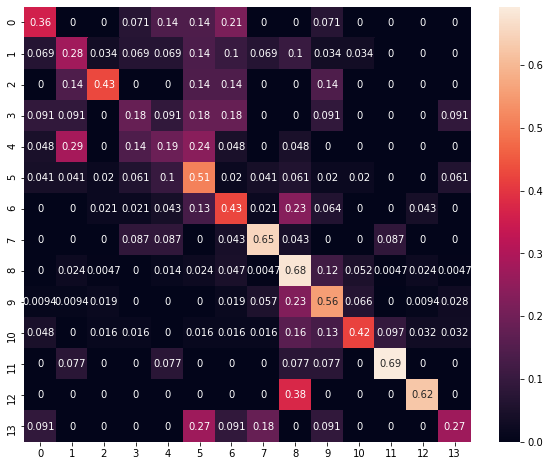

In [0]:
report(Y_valid, preds)

                                    precision    recall  f1-score   support

               Appeal_to_Authority       0.82      0.95      0.88       130
          Appeal_to_fear-prejudice       0.75      0.79      0.77       265
    Bandwagon,Reductio_ad_hitlerum       0.76      1.00      0.87        65
           Black-and-White_Fallacy       0.75      0.96      0.84        96
         Causal_Oversimplification       0.80      0.92      0.85       188
                             Doubt       0.82      0.85      0.84       444
         Exaggeration,Minimisation       0.72      0.73      0.72       419
                       Flag-Waving       0.70      0.89      0.79       206
                   Loaded_Language       0.83      0.78      0.80      1911
             Name_Calling,Labeling       0.79      0.74      0.76       952
                        Repetition       0.78      0.63      0.70       559
                           Slogans       0.70      0.97      0.81       116
       Thou

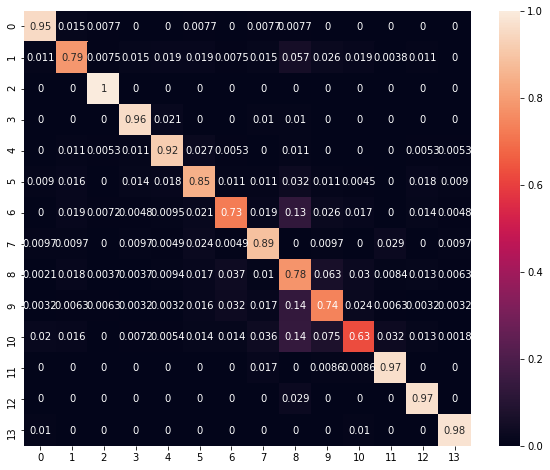

In [0]:
model.fit(X_train, Y_train)
report(Y_train, model.predict(X_train))

In [0]:
Train = Dataset(articles_folder=train_folder, labels_file=train_labels_file)
Test =Dataset(articles_folder=dev_folder, labels_file=dev_labels_file)

Read 6129 annotations from 357 articles
Read 1063 annotations from 74 articles


In [0]:
Train_trans=SLDataset(Train)
Test_trans=SLDataset(Test)

In [0]:
fts=FeatureExtraction(Train,Test)
fts.get_features()

In [0]:
X_train, X_test = fts.train_features, fts.dev_features
Y_train, Y_test = Train.df['Labels'], Test.df['Labels']

In [0]:
from sklearn.linear_model import LogisticRegression as LR

In [0]:
model=LR(penalty='l2', class_weight='balanced', random_state=1234, solver='liblinear')
model.fit(X_train, Y_train)
preds=model.predict(X_test)

                                    precision    recall  f1-score   support

               Appeal_to_Authority       0.00      0.00      0.00        14
          Appeal_to_fear-prejudice       0.20      0.23      0.21        44
    Bandwagon,Reductio_ad_hitlerum       0.29      0.40      0.33         5
           Black-and-White_Fallacy       0.18      0.18      0.18        22
         Causal_Oversimplification       0.28      0.28      0.28        18
                             Doubt       0.41      0.45      0.43        66
         Exaggeration,Minimisation       0.39      0.35      0.37        68
                       Flag-Waving       0.70      0.71      0.70        87
                   Loaded_Language       0.63      0.77      0.69       325
             Name_Calling,Labeling       0.56      0.53      0.55       183
                        Repetition       0.44      0.26      0.33       145
                           Slogans       0.33      0.20      0.25        40
       Thou

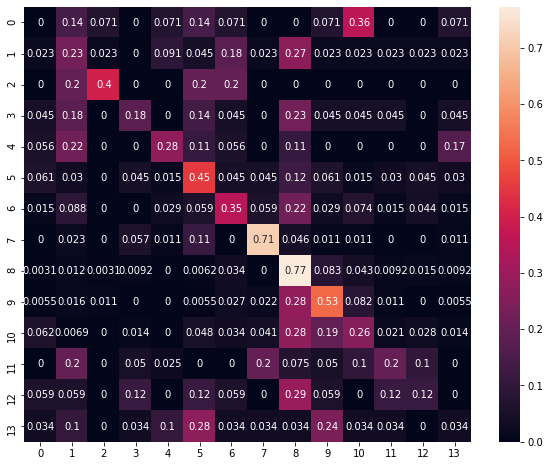

In [0]:
report(Y_test, preds)